In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import gcf
import numpy as np 
from einops import rearrange
from sklearn import cluster
from sklearn import metrics
from collections import Counter
%load_ext autoreload
%autoreload 2
from sklearn.decomposition import non_negative_factorization
import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition._nmf import NMF
import math
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique 
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3,get_indices_2ormore#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.cdnmf_fast module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/d

In [6]:
import sklearn
help(sklearn)

Help on package sklearn:

NAME
    sklearn

DESCRIPTION
    Machine learning module for Python
    
    sklearn is a Python module integrating classical machine
    learning algorithms in the tightly-knit world of scientific Python
    packages (numpy, scipy, matplotlib).
    
    It aims to provide simple and efficient solutions to learning problems
    that are accessible to everybody and reusable in various contexts:
    machine-learning as a versatile tool for science and engineering.
    
    See http://scikit-learn.org for complete documentation.

PACKAGE CONTENTS
    __check_build (package)
    _build_utils (package)
    _config
    _distributor_init
    _isotonic
    base
    calibration
    cluster (package)
    compose (package)
    conftest
    covariance (package)
    cross_decomposition (package)
    datasets (package)
    decomposition (package)
    discriminant_analysis
    dummy
    ensemble (package)
    exceptions
    experimental (package)
    externals (package)
   

In [ ]:

#load data
def cv_nmf_missing(data, n_components,alpha=0.01, l1_ratio = 1.,p_holdout = .3):
    
    missings = np.asarray(np.where(np.isnan(data))).transpose()
    presents = np.asarray(np.where(~np.isnan(data))).transpose()

    M = np.where(np.random.rand(presents.shape[0]) > p_holdout)[0]
    N = np.where(np.random.rand(presents.shape[0]) < p_holdout)[0]

    nmf = NMF(n_components=n_components, alpha=alpha, l1_ratio=l1_ratio, solver='mu', init = 'random', max_iter=500)

    data_tr = data.copy()
    for i in range(len(M)):
        data_tr[presents[M[i],0] ,presents[M[i],1]]  =np.nan

    data_te = data.copy()
    for i in range(len(N)):
        data_te[presents[N[i],0] ,presents[N[i],1]]  =np.nan

    nmf.fit(data_tr)

    tr_nmf_embedding = nmf.transform(data_tr)
    te_nmf_embedding = nmf.transform(data_te)

    tr_nmf_recon = nmf.inverse_transform(tr_nmf_embedding)
    te_nmf_recon = nmf.inverse_transform(te_nmf_embedding)
    tr_err = np.nanmean((data_tr - tr_nmf_recon)**2)
    te_err= np.nanmean((data_te - te_nmf_recon)**2)
    
    return(tr_err, te_err)


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        #cmap(np.linspace(maxval, minval, n)))
        cmap(np.linspace(minval,maxval , n)))
    return new_cmap

def fix_pdcsv(csv):
    
    csv_rownames = np.asarray(csv.iloc[:,0])
    csv = csv.iloc[:,1:]
    csv.index = csv_rownames
    return(csv)

def fill_df_na(data, indices):
    
    for i in range(indices.shape[0]):
        data.iloc[indices[i,0],indices[i,1]] = np.nan
        
    return(data)

def get_colors(structures, palettes, alpha):
    
    strs_unique = np.unique(structures)
    nstr = len(strs_unique)
    cs = sns.color_palette("Spectral", nstr)
    
    #print(np.asarray(cs).shape, np.expand_dims(np.ones(12),1).shape)
    cs_alphas = np.hstack([np.asarray(cs), alpha*np.expand_dims(np.ones(12),1)])
    color_str = {}
    for i in range(nstr):
        #print(i)
        color_str[strs_unique[i]] = cs_alphas[i]
    #print(color_str['CB'])
    #print(color_str)
    output = np.zeros((len(structures),4), dtype  =float)
    for i in range(len(structures)):
        #print(np.asarray(color_str[structures[i]]))
        output[i] = np.asarray(color_str[structures[i]])
        
    return(output,color_str)

#arr = np.linspace(0, 50, 100).reshape((10, 10))
#fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('Greys')
new_cmap = truncate_colormap(cmap, 0.1,1.)





workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

#read data
TOP_DIR = workingdirectory
INPUT_JSON = workingdirectory + '/data/meta/input_011520.json'
EXPERIMENTS_EXCLUDE_JSON = workingdirectory + '/data/meta/experiments_exclude.json'
input_data = ju.read(INPUT_JSON)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
cache = VoxelModelCache(manifest_file=manifest_file)
st = cache.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}
major_structures = np.load(workingdirectory + '/data/meta/major_structures.npy')
major_structure_ids = np.load(workingdirectory + '/data/meta/major_structure_ids.npy')
data_info = pd.read_excel(workingdirectory + '/data/meta/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
with open('data/meta/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
ontological_order_leaves = np.load(workingdirectory + '/data/meta/ontological_order_leaves_v3.npy')
COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
folder =  '/Users/samsonkoelle/mouse_connectivity_models/data/raw/'

In [2]:
asdf = {'asdf':'ppp'}
'ppp' in asdf

False

In [2]:

# TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
# INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
# EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
# FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
# OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

# input_data = ju.read(INPUT_JSON)
# manifest_file = input_data.get('manifest_file')
# manifest_file = os.path.join(TOP_DIR, manifest_file)
# experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

# #its unclear why the hyperparameters are loaded from the output directory
# cache = VoxelModelCache(manifest_file=manifest_file)
# major_structures = input_data.get('structures')

#wt_conn = pd.read_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/connectivities/el_leafsurf_leafsmth_leafleaf_meandata_0428_log6.csv',  header=[0,1])
wt_conn = pd.read_csv('/Users/samsonkoelle/mouse_connectivity_models/paper/connectivities/el_leafsurf_leafsmth_leafleaf_C57BL6J0428_log6.csv',  header=[0,1])
wt_conn = fix_pdcsv(wt_conn)
#dists = pd.read_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/distances.csv',  header=[0,1])
#dists = fix_pdcsv(dists)

In [3]:
dists = np.load('data/meta/distances_leaf_leaf.npy')

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()

ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#get ontological order structures and leaf major regions
#oos_ic_majors = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/oos_ic_majors_v3.npy')
ool_ic_majors = np.load('data/meta/ool_ic_majors_names_v3_0610.npy')
ool_i_majors = np.load('data/meta/ool_i_majors_names_v3_0610.npy')
ool_ic_majors = np.asarray([ia_map[ool_ic_majors[i ]] for i in range(len(ool_ic_majors))])
ool_i_majors = np.asarray([ia_map[ool_i_majors[i ]] for i in range(len(ool_i_majors))])
#ccol,ccol_dict = get_colors(np.asarray(ool_ic_majors), sns.color_palette("Spectral", 12), 1.)
#crow,crow_dict = get_colors(np.asarray(ool_i_majors), sns.color_palette("Spectral", 12), 1.)
reo = np.asarray([4,7,2,1,10,9,11,3,5,8,6,0])
low_values = np.asarray(np.where(dists < 15)).transpose()

In [4]:
data = np.asarray(fill_df_na(wt_conn, low_values))
rss= np.nansum(data, axis = 1)
ids = np.where(rss > 0.)[0]
data= data[ids]

wt_conn.columns.names = np.asarray(['Hemisphere', 'Structure'])
hemi_labels = wt_conn.columns.get_level_values("Hemisphere")
hemi_pal = sns.color_palette("cubehelix", n_colors = hemi_labels.unique().size)
hemi_lut = dict(zip(map(str, hemi_labels.unique()), hemi_pal))
hemi_colors = pd.Series(hemi_labels, index=wt_conn.columns).map(hemi_lut)

targ_str_labels = ool_ic_majors#wt_conn.columns.get_level_values("Structure")
targ_str_pal = sns.color_palette("tab20", n_colors = np.unique(targ_str_labels).size)
targ_str_lut = dict(zip(map(str, np.unique(targ_str_labels)), targ_str_pal))
targ_str_colors = pd.Series(targ_str_labels, index=wt_conn.columns).map(targ_str_lut)

source_str_labels = ool_i_majors
source_str_pal = sns.color_palette("tab20", n_colors = np.unique(source_str_labels).size)
source_str_lut = dict(zip(map(str, np.unique(source_str_labels)), source_str_pal))
source_str_colors = pd.Series(source_str_labels, index=wt_conn.index).map(source_str_lut)

arr_targ = np.zeros((1123,2), dtype = object)
arr_targ[:,0] = hemi_colors
arr_targ[:,1] = targ_str_colors
combined_colors_targ = pd.DataFrame(arr_targ, index = wt_conn.columns)

arr_source = np.zeros((564,1), dtype = object)
arr_source[:,0] = source_str_colors
combined_colors_source = pd.DataFrame(arr_source, index = wt_conn.index)


dists = pd.DataFrame(dists, index= wt_conn.index, columns = wt_conn.columns)
combined_colors_targ.columns = np.asarray(['Hemisphere','Major Structure'])
combined_colors_source.columns = np.asarray(['Major Structure'])

strs_unique = np.unique(ool_ic_majors)
nstr = len(strs_unique)
cs = sns.color_palette("tab20", nstr)

#print(np.asarray(cs).shape, np.expand_dims(np.ones(12),1).shape)
#cs_alphas = np.hstack([np.asarray(cs), alpha*np.expand_dims(np.ones(12),1)])
color_str = {}
for i in range(nstr):
    #print(i)
    color_str[strs_unique[i]] = cs[i]
  
cs_hemi = sns.color_palette("cubehelix", 2)

color_hemi = {}
hemis = np.asarray(['Ipsi','Contra'])
for i in range(2):
    #print(i)
    color_hemi[hemis[i]] = cs_hemi[i]

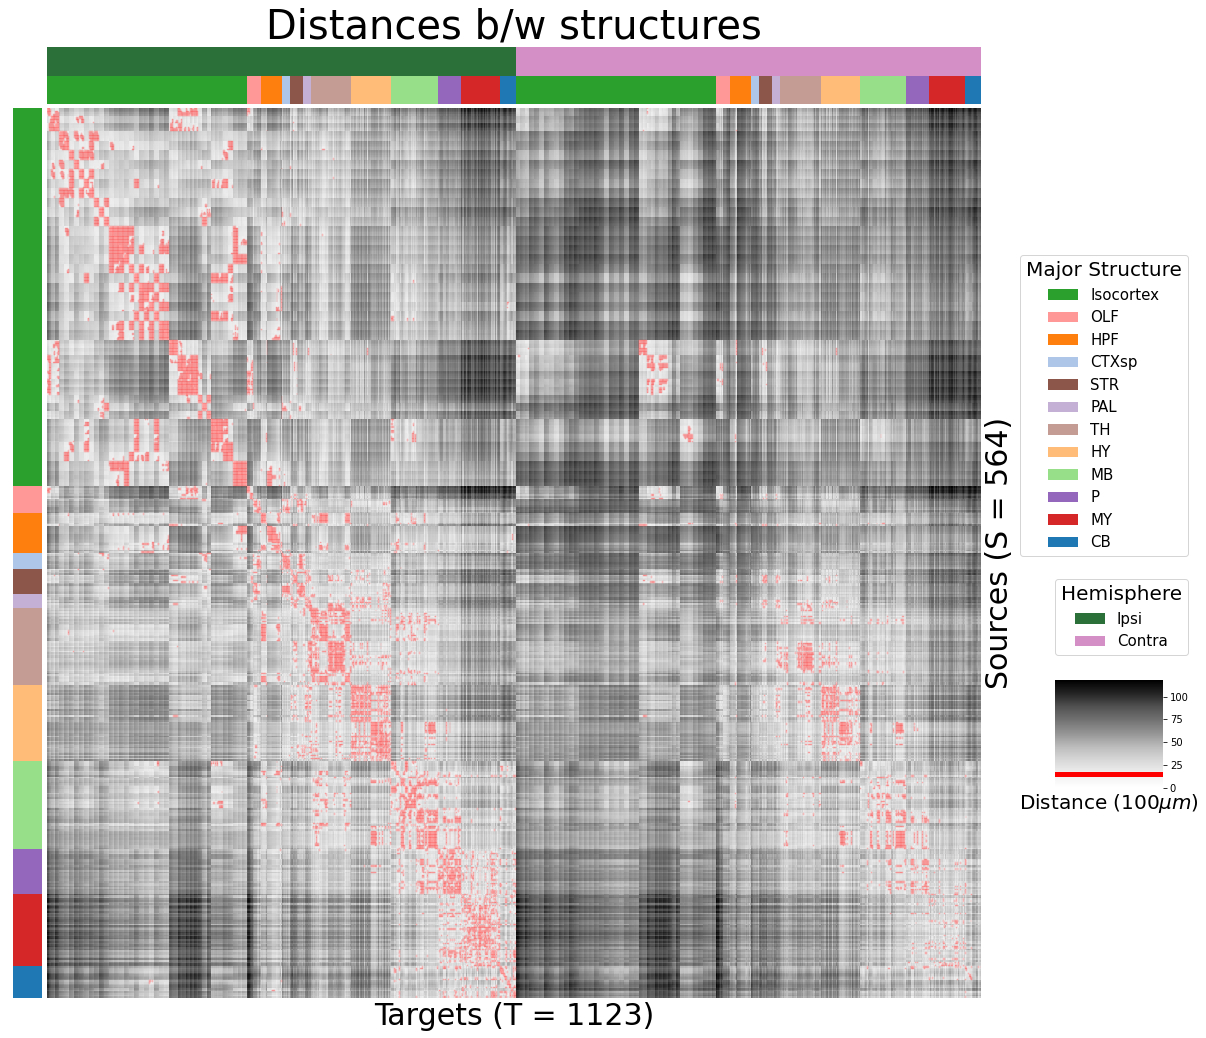

In [6]:
g = sns.clustermap(dists,
                   col_cluster = False,
                   row_cluster = False, 
                   figsize = (15,15), 
                   cmap = 'Greys',
                   col_colors = combined_colors_targ, 
                   row_colors = combined_colors_source, 
                   dendrogram_ratio=0.001)
g.ax_col_colors.set_yticks([])
g.ax_row_colors.set_xticks([])
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xlabel('Targets (T = 1123)', fontsize = 30)
g.ax_heatmap.set_ylabel('Sources (S = 564)', fontsize = 30)
ax = gcf().add_axes((0.55,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=color_str[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.11, .8), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

ax2 = gcf().add_axes((0.55,.5,0.,0.))
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
for label in hemis:
    ax2.bar(0, 0, color=color_hemi[label], label=label, linewidth=0.)
l4 = ax2.legend(title='Hemisphere', ncol=1, bbox_to_anchor=(1.11, .5), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

g.ax_cbar.set_xlabel('Distance ' +  r'$(100 \mu m)$', rotation=0, fontsize = 20)
g.ax_cbar.set_position([.98,0.3,.1,.1])
g.ax_cbar.axhline(15, color = 'red', linewidth = 5)
g.ax_col_colors.set_title('Distances b/w structures', fontsize = 40)
for i in range(low_values.shape[0]):
    #print(i)
    g.ax_heatmap.add_patch(Rectangle((low_values[i][1],low_values[i][0]), 1, 1, fill=False, edgecolor='red', lw=.15))

g.savefig('paper/KoelleConn_fromlocal_0623/figs/distances_leafs.png', bbox_inches = 'tight',pad_inches = 0)




In [6]:
data = np.asarray(fill_df_na(wt_conn, low_values))
rss= np.nansum(data, axis = 1)
ids = np.where(rss > 0.)[0]
data= data[ids]


In [7]:
from sklearn.decomposition._nmf import NMF

#load data
def cv_nmf_missing(data, n_components,alpha=0.01, l1_ratio = 1.,p_holdout = .3):
    
    missings = np.asarray(np.where(np.isnan(data))).transpose()
    presents = np.asarray(np.where(~np.isnan(data))).transpose()

    M = np.where(np.random.rand(presents.shape[0]) > p_holdout)[0]
    N = np.where(np.random.rand(presents.shape[0]) < p_holdout)[0]

    nmf = NMF(n_components=n_components, alpha=alpha, l1_ratio=l1_ratio, solver='mu', init = 'random', max_iter=500)

    data_tr = data.copy()
    for i in range(len(M)):
        data_tr[presents[M[i],0] ,presents[M[i],1]]  =np.nan

    data_te = data.copy()
    for i in range(len(N)):
        data_te[presents[N[i],0] ,presents[N[i],1]]  =np.nan

    nmf.fit(data_tr)

    tr_nmf_embedding = nmf.transform(data_tr)
    te_nmf_embedding = nmf.transform(data_te)

    tr_nmf_recon = nmf.inverse_transform(tr_nmf_embedding)
    te_nmf_recon = nmf.inverse_transform(te_nmf_embedding)
    tr_err = np.nanmean((data_tr - tr_nmf_recon)**2)
    te_err= np.nanmean((data_te - te_nmf_recon)**2)
    
    return(tr_err, te_err)

In [8]:
train_err = []
test_err = []
nrep = 8
tr_results = np.zeros((nrep,8))
te_results = np.zeros((nrep,8))
for n in range(1,9):
    print(n)
    for r in range(nrep):
        #print(r)
        tr_results[r,n-1] , te_results[r,n-1] = cv_nmf_missing(data, n_components = n*10 ,alpha=.0002, l1_ratio = 1.,p_holdout = .3)

1


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is depre

2


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:2464: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in ve

3


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is depre

4


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is depre

5


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is depre

6


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is depre

7


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is depre

8


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is depre

In [10]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  This is separate from the ipykernel package so we can avoid doing imports until


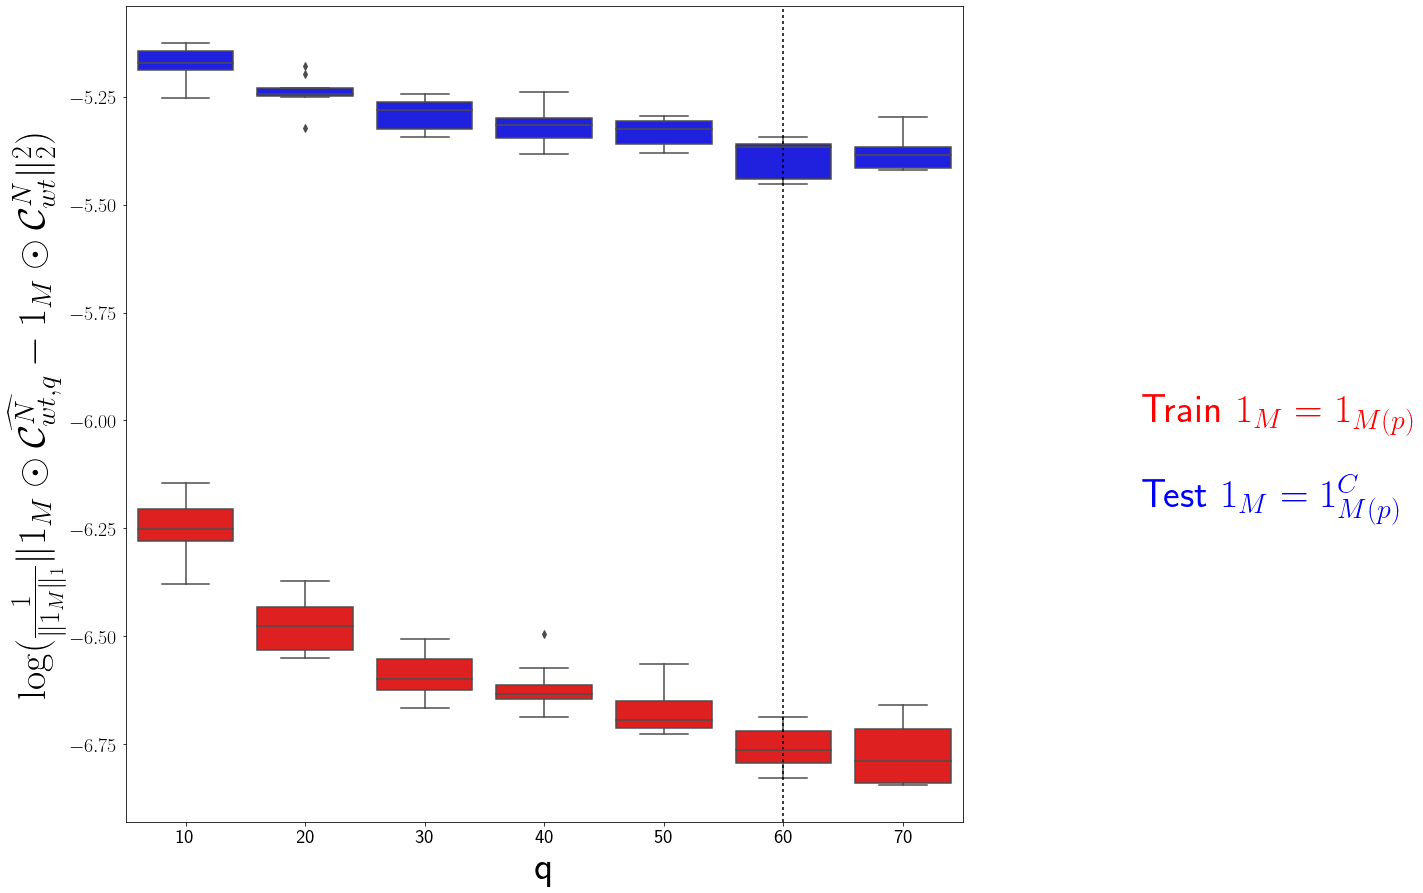

In [16]:
#alpha .0002
splits = np.asarray(['Train','Test'])
colorsplits = {}
colorsplits['Train'] = 'red'
colorsplits['Test']=  'blue'

fig , ax = plt.subplots(figsize = (15,15))
sns.boxplot( data = np.log10(te_results[:,1:]), ax=  ax, color= 'blue')
sns.boxplot( data = np.log10(tr_results[:,1:]), ax=  ax, color= 'red')
#ax.set_xticklabels(list(range(1,11)))
ax.axvline(5, color='k', dashes=[2,2])
ax.text(8,-6, 'Train '+ r"$1_M = 1_{M(p)}$",color = 'red', fontsize = 40)
ax.text(8,-6.2, 'Test '+ r"$1_M = 1_{M(p)}^C$",color = 'blue', fontsize = 40)
ax.set_ylabel(r"$\log(\frac{1}{\|1_{M}\|_1 } \| 1_{M} \odot \widehat {\mathcal C_{wt,q}^N} - 1_{M} \odot \mathcal C_{wt}^N \|_2^2)$", fontsize = 40)
ax.set_xlabel('q', fontsize = 40)
ax.set_xticklabels(np.asarray(list(range(1,8)))*10, fontsize = 20)
plt.yticks(fontsize = 20)
fig.savefig('paper/KoelleConn_fromlocal_0623/figs/nmf_test_train.png', bbox_inches = 'tight',
   pad_inches = 0)
# #ax.legend()

In [26]:
data = np.asarray(fill_df_na(wt_conn, low_values))
rss= np.nansum(data, axis = 1)
ids = np.where(rss > 0.)[0]
data = data[ids]

ncomp = 15
nreps = 10
components = np.zeros((nreps,ncomp,1123))
for r in range(nreps):
    print(r)
    nmf = NMF(n_components=ncomp, alpha=.0002, l1_ratio=1., solver='mu', init = 'random', max_iter=500)
    nmf.fit(data)
    components[r] = nmf.components_

0


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


2


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


3


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


4


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:2464: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


5
6


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


7


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


8


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


9


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [31]:
combined = rearrange(components, 'r c p -> (r c) p')
nclusts = np.asarray([10,20,30,40,50])
nreps_cluster = 15
np.nanmax(data)

results = np.zeros(nclusts.shape[0])
for d in range(len(nclusts)):
    print(d)
    nclust = nclusts[d]
    cluster_reps = np.zeros((nreps_cluster,combined.shape[0]))
    for c in range(nreps_cluster):
        
        kmeans  = cluster.KMeans(n_clusters=nclust)
        kmeans.fit(combined)
        clusts = kmeans.labels_[kmeans.labels_.argsort()]
        cluster_reps[c] = kmeans.labels_
        
        
        rands = np.zeros((nreps_cluster,nreps_cluster))
        rands[:] = np.nan
    for i in range(nreps_cluster):
        #print(i)
        for j in range(nreps_cluster):
            if i != j:
                rands[i,j] = metrics.adjusted_rand_score(cluster_reps[i], cluster_reps[j])
                    
    results[d] = np.nanmean(rands)
    
results

0
1
2
3
4


array([0.77254373, 0.84498059, 0.93295705, 0.92982747, 0.88586173])

In [33]:
rcomb = np.vstack([np.asarray(list(range(1,6)))*10 ,results])
stab = pd.DataFrame(rcomb, index = ['q','Rand index']).transpose()
print(stab.transpose().to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &          0 &          1 &          2 &          3 &          4 \\
\midrule
q          &  10.000000 &  20.000000 &  30.000000 &  40.000000 &  50.000000 \\
Rand index &   0.772544 &   0.844981 &   0.932957 &   0.929827 &   0.885862 \\
\bottomrule
\end{tabular}



In [34]:
nclust = 30
kmeans  = cluster.KMeans(n_clusters=nclust)
kmeans.fit(combined)
clusts = kmeans.labels_[kmeans.labels_.argsort()]
cclusts = Counter(clusts)
topclusts  = np.asarray(list(cclusts.keys()))[np.asarray(list(cclusts.values())).argsort()][-15:]
top_clust_inds = np.where(np.isin(clusts, topclusts))[0]

In [35]:
#multiind cre_inds, layers, summary
#n_clust * nreps_cluster
sel_labels = np.zeros(ncomp*nreps, dtype = str)
sel_labels[top_clust_inds] = 'Yes'
sel_labels[np.setdiff1d(list(range(ncomp*nreps)),top_clust_inds)] = 'No'
rep_labels = np.asarray(np.repeat(list(range(10)),15)[kmeans.labels_.argsort()], dtype = str)
clust_labels = np.asarray(clusts, dtype = str)
row_multi_ind = np.vstack([sel_labels,rep_labels,clust_labels])
row_multi_ind = np.asarray(row_multi_ind, dtype = str)
row_multi_ind_tuples = list(zip(*row_multi_ind))
row_multi_ind_tuples = pd.MultiIndex.from_tuples(row_multi_ind_tuples, names=['Top 15 basis','Replicate', 'Cluster'])

sel_labels = row_multi_ind_tuples.get_level_values('Top 15 basis')
sel_pal = sns.color_palette("Pastel1", n_colors = np.unique(sel_labels).shape[0])
sel_lut = dict(zip(map(str, np.unique(sel_labels)), sel_pal))
sel_colors = pd.Series(sel_labels, index=row_multi_ind_tuples).map(sel_lut)

rep_labels = row_multi_ind_tuples.get_level_values("Replicate")
#rep_labels = pd.Index(rep_labels, dtype = object)#pd.I(rep_labels, index=  np.asarray( list(range(150)) ,dtype = object))
rep_pal = sns.color_palette("tab20", n_colors = np.unique(rep_labels).shape[0])
rep_lut = dict(zip(map(str, np.unique(rep_labels)), rep_pal))
rep_colors = pd.Series(rep_labels, index=row_multi_ind_tuples).map(rep_lut)


#clust_labels = pd.DataFrame(clust_labels, index=  np.asarray( list(range(150)) ,dtype = object))
clust_labels = row_multi_ind_tuples.get_level_values("Cluster")
#clust_labels= pd.Index(clust_labels, dtype = object)
clust_pal = sns.color_palette("Paired", np.unique(clust_labels).shape[0]) #sns.cubehelix_palette(summary_labels.unique().size, light=.9, dark=0.1, reverse=False, start=0, rot=-1, hue = 1)#sns.cubehelix_palette(summary_labels.unique().size, light=1., dark=0., reverse=False, start=0, rot=-1, hue = 1)
clust_lut = dict(zip(map(str, np.unique(clust_labels)), clust_pal))
clust_colors = pd.Series(clust_labels, index=row_multi_ind_tuples).map(clust_lut)

arr = np.zeros((ncomp*nreps,3), dtype = object)
arr[:,0] = sel_colors
arr[:,1] = rep_colors
arr[:,2] = clust_colors
combined_colors = pd.DataFrame(arr, index = clust_colors.index)

toplot = pd.DataFrame(np.log10(combined[kmeans.labels_.argsort()]), index= combined_colors.index)

/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10


In [36]:
arr_targ = np.zeros((1123,2), dtype = object)
arr_targ[:,0] = hemi_colors
arr_targ[:,1] = targ_str_colors
combined_colors_targ = pd.DataFrame(arr_targ, index = wt_conn.columns)


toplot.columns = combined_colors_targ.index
toplot[toplot < -6] = -6

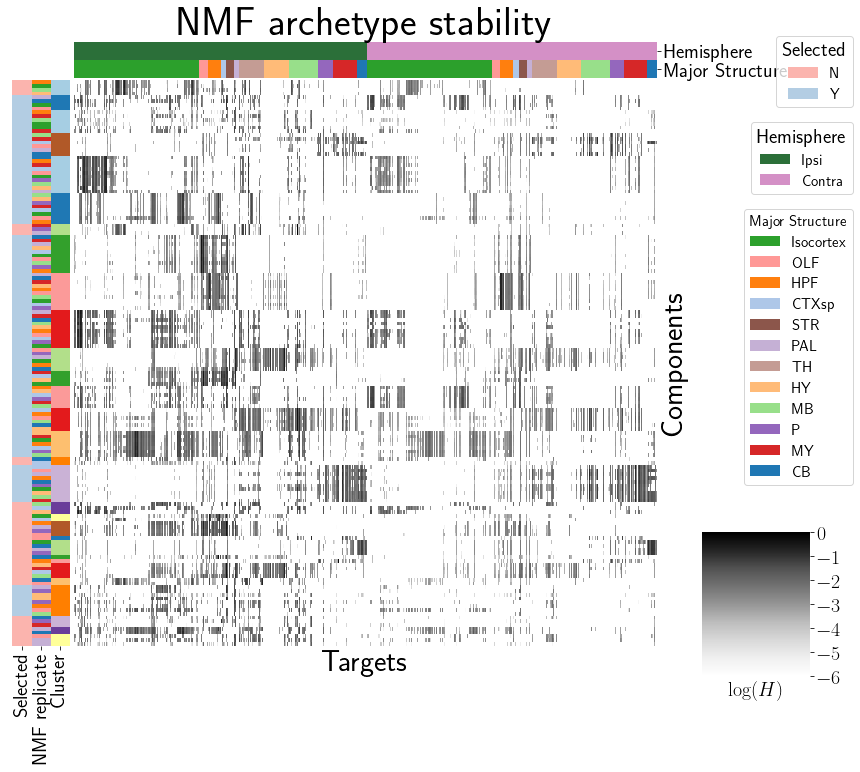

In [40]:
g = sns.clustermap(toplot , 
                   vmin = -6, 
                   vmax= 0, 
                   row_cluster=False,
                   col_cluster=False,
                   row_colors=combined_colors, 
                   col_colors = combined_colors_targ,
                   cbar_pos = [.98,0.1,.15,.2],
                   dendrogram_ratio=0.001,
                  cmap = 'Greys')
g.ax_col_colors.set_yticklabels(['Hemisphere','Major Structure'], fontsize = 20)
g.ax_row_colors.set_xticklabels(['Selected','NMF replicate','Cluster'], fontsize = 20)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xlabel('Targets', fontsize = 30)
g.ax_heatmap.set_ylabel('Components', fontsize = 30)
g.ax_cbar.set_xlabel('$\log( H)$', rotation=0, fontsize = 20)

ax = gcf().add_axes((0.55,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=color_str[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.2, .76), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=15)    

ax2 = gcf().add_axes((0.55,.5,0.,0.))
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
for label in hemis:
    ax2.bar(0, 0, color=color_hemi[label], label=label, linewidth=0.)
l4 = ax2.legend(title='Hemisphere', ncol=1, bbox_to_anchor=(1.2, .88), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

ax2 = gcf().add_axes((0.56,.5,0.,0.))
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
for label in sel_labels.unique():
    ax2.bar(0, 0, color=sel_lut[label], label=label, linewidth=0.)
l4 = ax2.legend(title='Selected', ncol=1, bbox_to_anchor=(1.2, 1.), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

for t in g.ax_cbar.get_yticklabels():
     t.set_fontsize(20)
g.ax_col_colors.set_title('NMF archetype stability', fontsize = 40)
g.savefig('paper/KoelleConn_fromlocal_0623/figs/nmfcluster.png', bbox_inches = 'tight', pad_inches = 0)

In [48]:
archetypes = np.zeros((ncomp,wt_conn.shape[1]))
for c in range(ncomp):
    archetypes[c] = np.mean(combined[np.where(kmeans.labels_ == topclusts[c])], axis = 0)
    
lowlim = -6
toplot = np.log(archetypes)#archetypes#np.log(archetypes)
toplot[np.where(toplot< lowlim)] = lowlim
toplot = pd.DataFrame(toplot, columns = wt_conn.columns)

/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [49]:
targs = np.asarray(list(wt_conn.columns))[:,1]
layers_targs = np.zeros(targs.shape[0], dtype = object)
for i in range(targs.shape[0]):
    if np.asarray(list(targs))[i][-3:] == '2/3':
        layers_targs[i] = '2/3'
    if np.asarray(list(targs))[i][-1:] == '1':
        layers_targs[i] = '1'
    if np.asarray(list(targs))[i][-1:] == '4':
        layers_targs[i] = '4'
    if np.asarray(list(targs))[i][-1:] == '5':
        layers_targs[i] = '5'    
    if np.asarray(list(targs))[i][-2:] == '6a':
        layers_targs[i] = '6a' 
    if np.asarray(list(targs))[i][-2:] == '6b':
        layers_targs[i] = '6b'

In [50]:
wt_conn.columns.names = np.asarray(['Hemisphere', 'Structure'])
hemi_labels = wt_conn.columns.get_level_values("Hemisphere")
hemi_pal = sns.color_palette("cubehelix", n_colors = hemi_labels.unique().size)
hemi_lut = dict(zip(map(str, hemi_labels.unique()), hemi_pal))
hemi_colors = pd.Series(hemi_labels, index=wt_conn.columns).map(hemi_lut)

targ_str_labels = ool_ic_majors#wt_conn.columns.get_level_values("Structure")
targ_str_pal = sns.color_palette("tab20", n_colors = np.unique(targ_str_labels).size)
targ_str_lut = dict(zip(map(str, np.unique(targ_str_labels)), targ_str_pal))
targ_str_colors = pd.Series(targ_str_labels, index=wt_conn.columns).map(targ_str_lut)

layer_labels_col = np.asarray(layers_targs, dtype = str)#col_multi_ind_tuples.get_level_values("Layer")
layer_pal = sns.color_palette("Set1", n_colors = 6) #sns.cubehelix_palette(layer_labels.unique().size, light=1., dark=0., reverse=False, start=0, rot=-1, hue = 1)
layer_lut_col = dict(zip(map(str, np.unique(np.asarray(layer_labels_col, dtype = str))[1:]), layer_pal))
layer_colors = pd.Series(layer_labels_col, index=wt_conn.columns).map(layer_lut_col)


# arr_targ = np.zeros((1123,3), dtype = object)
# arr_targ[:,0] = hemi_colors
# arr_targ[:,1] = targ_str_colors
# arr_targ[:,2] = layer_colors
# combined_colors_targ = pd.DataFrame(arr_targ, index = wt_conn.columns)

component_labels = np.asarray(list(range(15)), dtype = str)#col_multi_ind_tuples.get_level_values("Layer")
component_pal = sns.color_palette("prism", n_colors = 15) #sns.cubehelix_palette(layer_labels.unique().size, light=1., dark=0., reverse=False, start=0, rot=-1, hue = 1)
component_lut = dict(zip(map(str, np.unique(np.asarray(component_labels, dtype = str))), component_pal))
component_colors = pd.Series(component_labels, index=list(range(15))).map(component_lut)


In [51]:
alpha = .0002
W, H, n_iter = non_negative_factorization(data, n_components=ncomp, init='custom', solver = 'mu',random_state=0, update_H=False, H=archetypes,l1_ratio  = 1, alpha = alpha, regularization='both')
W_pd = pd.DataFrame(W, index = combined_colors_source.index[ids])
W_pd_log = np.log10(W_pd)
W_pd_log[W_pd_log < -6] = -6

/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


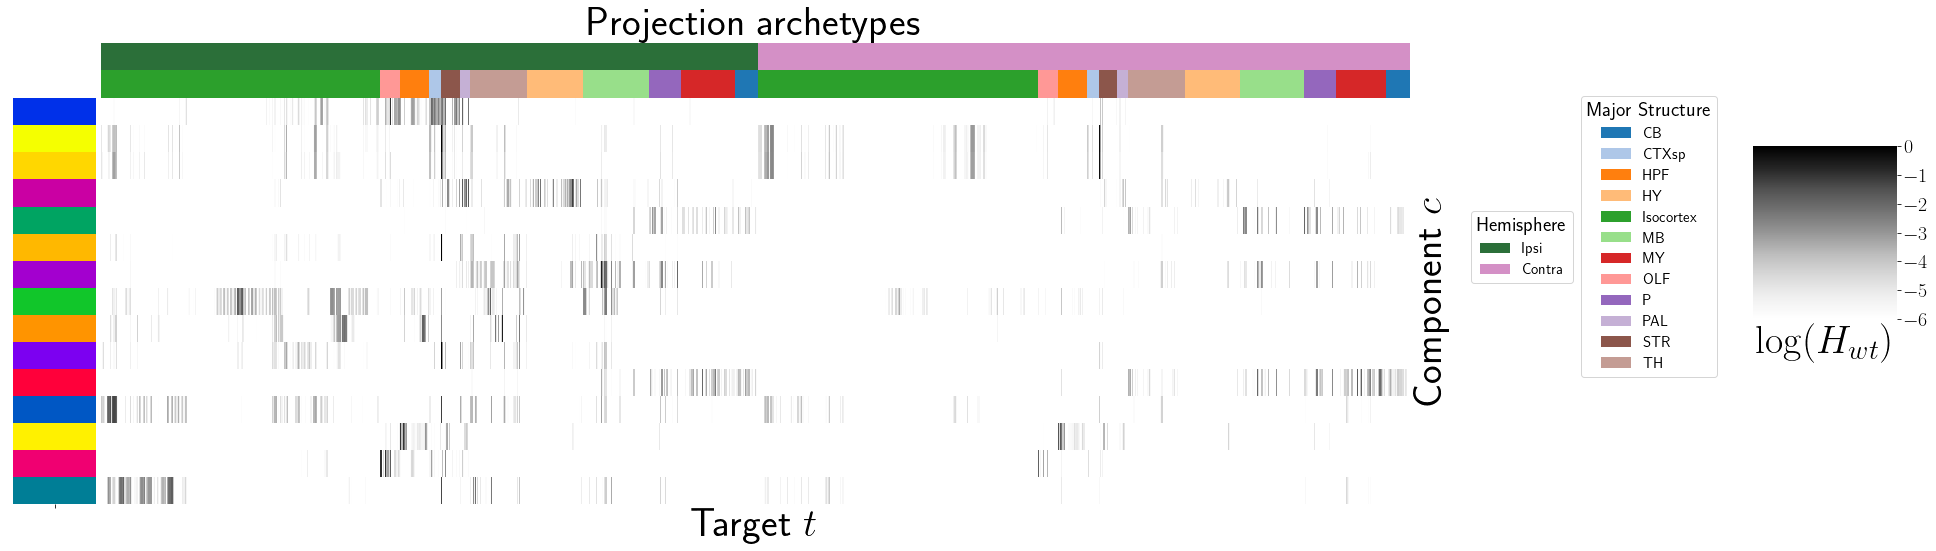

In [62]:
g= sns.clustermap(toplot, 
                  vmin = -6,
                  figsize = (20,8),
                  vmax=  0,
                  col_cluster=False,
                  row_cluster=False,
                  col_colors=combined_colors_targ, 
                  cbar_pos = [1.03,0.22,.05,.2],
                  colors_ratio=0.06,
                  dendrogram_ratio=0.001,
                  row_colors = component_colors,
                 cmap = 'Greys')
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_ylabel('Component ' + r"$c$", fontsize = 40)
g.ax_heatmap.set_xlabel('Target ' + r"$t$", fontsize = 40)
g.ax_heatmap.set_yticks([])
g.ax_col_colors.set_yticks([])
g.ax_cbar.set_xlabel('$\log( H_{wt})$', rotation=0, fontsize = 40)
g.ax_cbar.set_position([1.22,0.5,.1,.3])

ax = gcf().add_axes((0.55,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.unique(targ_str_labels):
    ax.bar(0, 0, color=targ_str_lut[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.2, .9), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

ax2 = gcf().add_axes((0.55,.5,0.,0.))
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
for label in hemis:
    ax2.bar(0, 0, color=color_hemi[label], label=label, linewidth=0.)
l4 = ax2.legend(title='Hemisphere', ncol=1, bbox_to_anchor=(1.1, .7), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

for t in g.ax_cbar.get_yticklabels():
     t.set_fontsize(20)

g.ax_col_colors.set_title('Projection archetypes', fontsize = 40)

g.savefig('paper/KoelleConn_fromlocal_0623/figs/H_wt', pad_inches = 0)

In [64]:
#comb_data = pd.concat([wt_conn,Cux2_conn,Ntsr1_conn,Rbp4_conn,Tlx3_conn])
#comb_data = pd.concat([wt_conn,Cux2_conn,Ntsr1_conn,Rbp4_conn,Tlx3_conn])
#gis are structures with nonzero connectivity
#nonzero_leafs  = np.where(np.sum(wt_conn, axis = 1) !=0.)[0]

#get layers (inelegant)
layers= np.zeros(wt_conn.shape[0], dtype = object)
for i in range(wt_conn.shape[0]):
    if np.asarray(list(wt_conn.index))[i][-3:] == '2/3':
        layers[i] = '2/3'
    if np.asarray(list(wt_conn.index))[i][-1:] == '1':
        layers[i] = '1'
    if np.asarray(list(wt_conn.index))[i][-1:] == '4':
        layers[i] = '4'
    if np.asarray(list(wt_conn.index))[i][-1:] == '5':
        layers[i] = '5'    
    if np.asarray(list(wt_conn.index))[i][-2:] == '6a':
        layers[i] = '6a' 
        #print('6a')
    if np.asarray(list(wt_conn.index))[i][-2:] == '6b':
        layers[i] = '6b'
        
layer_labels_row = layers[ids]#col_multi_ind_tuples.get_level_values("Layer")
layer_pal_row = sns.color_palette("Set1", n_colors = 6) #sns.cubehelix_palette(layer_labels.unique().size, light=1., dark=0., reverse=False, start=0, rot=-1, hue = 1)
layer_lut_row = dict(zip(map(str, np.unique(np.asarray(layer_labels_row, dtype = str))[1:]), layer_pal_row))
layer_colors_row = pd.Series(layer_labels_row, index=wt_conn.index[ids]).map(layer_lut_row)

arr_targ = np.zeros((len(ids),2), dtype = object)
arr_targ[:,0] = source_str_colors[ids]
arr_targ[:,1] = layer_colors_row
#arr_targ[:,2] = layer_colors
combined_colors_source2 = pd.DataFrame(arr_targ, index = wt_conn.index[ids])

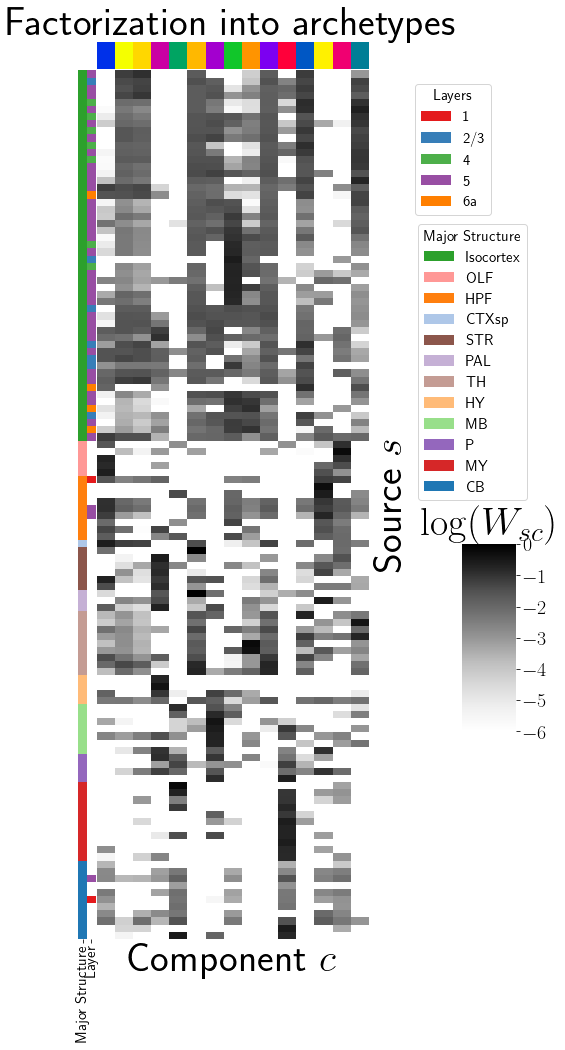

In [85]:
g= sns.clustermap(W_pd_log, vmin = -6, 
                  figsize = (5,13),
                  vmax=  0,
                  col_cluster=False, 
                  row_cluster=False,
                  cmap  = 'Greys',
                  row_colors = combined_colors_source2,
                  col_colors = component_colors,
                  cbar_pos = [1.1,0.25,.15,.2],
                 dendrogram_ratio=0.001)
                  #row_colors=crow[ids])
g.ax_col_colors.set_title('Factorization into archetypes', fontsize = 40)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_xlabel('Component ' + r"$c$", fontsize = 40)
g.ax_heatmap.set_ylabel('Source ' + r"$s$", fontsize = 40)
#g.ax_heatmap.set_yticks(np.asarray(list(range(W_pd_log.index.shape[0]))) + .5)
g.ax_heatmap.set_yticks([])
#g.ax_heatmap.set_yticklabels(W_pd_log.index, fontsize = 10)
g.ax_row_colors.set_xticklabels(['Major Structure','Layer'], fontsize = 15)
g.ax_cbar.set_title(r"$\log(W_{sc})$", rotation=0, fontsize = 40)
#g.ax_col_colors.set_yticklabels(['Component'], fontsize = 15)
g.ax_col_colors.set_yticks([])

ax = gcf().add_axes((0.55,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=color_str[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.3, .8), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=15)    

ax = gcf().add_axes((0.55,.9,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
#np.unique(np.asarray(layer_labels_col, dtype = str))
for label in np.unique(layer_labels_col)[1:-1]:
    ax.bar(0, 0, color=layer_lut_row[label], label=label, linewidth=0.)
    
l4 = ax.legend(title='Layers', ncol=1, bbox_to_anchor=(1.2, .95), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=15)    

for t in g.ax_cbar.get_yticklabels():
     t.set_fontsize(20)
        
# l4 = ax.legend(title='Layers', ncol=1, bbox_to_anchor=(1.3, .7), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=15)    
g.savefig('paper/KoelleConn_fromlocal_0623/figs/W_wt', pad_inches = 0)

In [69]:
output = np.log10(W@H)
output[np.where(np.isnan(data))] = np.nan
output = pd.DataFrame(output, columns = wt_conn.columns, index = wt_conn.index[ids])

output.columns.names = np.asarray(['Hemisphere', 'Structure'])
hemi_labels = wt_conn.columns.get_level_values("Hemisphere")
hemi_pal = sns.color_palette("cubehelix", n_colors = hemi_labels.unique().size)
hemi_lut = dict(zip(map(str, hemi_labels.unique()), hemi_pal))
hemi_colors = pd.Series(hemi_labels, index=wt_conn.columns).map(hemi_lut)

targ_str_labels = ool_ic_majors#wt_conn.columns.get_level_values("Structure")
targ_str_pal = sns.color_palette("tab20", n_colors = np.unique(targ_str_labels).size)
targ_str_lut = dict(zip(map(str, np.unique(targ_str_labels)), targ_str_pal))
targ_str_colors = pd.Series(targ_str_labels, index=wt_conn.columns).map(targ_str_lut)

source_str_labels = ool_i_majors
source_str_pal = sns.color_palette("tab20", n_colors = np.unique(source_str_labels).size)
source_str_lut = dict(zip(map(str, np.unique(source_str_labels)), source_str_pal))
source_str_colors = pd.Series(source_str_labels, index=wt_conn.index).map(source_str_lut)

arr_targ = np.zeros((1123,2), dtype = object)
arr_targ[:,0] = hemi_colors
arr_targ[:,1] = targ_str_colors
combined_colors_targ = pd.DataFrame(arr_targ, index = wt_conn.columns)

arr_source = np.zeros((564,1), dtype = object)
arr_source[:,0] = source_str_colors
combined_colors_source = pd.DataFrame(arr_source, index = wt_conn.index)


combined_colors_targ.columns = np.asarray(['Hemisphere','Major Structure'])
combined_colors_source.columns = np.asarray(['Major Structure'])

strs_unique = np.unique(ool_ic_majors)
nstr = len(strs_unique)
cs = sns.color_palette("tab20", nstr)

#print(np.asarray(cs).shape, np.expand_dims(np.ones(12),1).shape)
#cs_alphas = np.hstack([np.asarray(cs), alpha*np.expand_dims(np.ones(12),1)])
color_str = {}
for i in range(nstr):
    #print(i)
    color_str[strs_unique[i]] = cs[i]
  
cs_hemi = sns.color_palette("cubehelix", 2)

color_hemi = {}
hemis = np.asarray(['Ipsi','Contra'])
for i in range(2):
    #print(i)
    color_hemi[hemis[i]] = cs_hemi[i]

/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [82]:
low_values2 =np.asarray(np.where(dists.iloc[ids] < 15)).transpose()

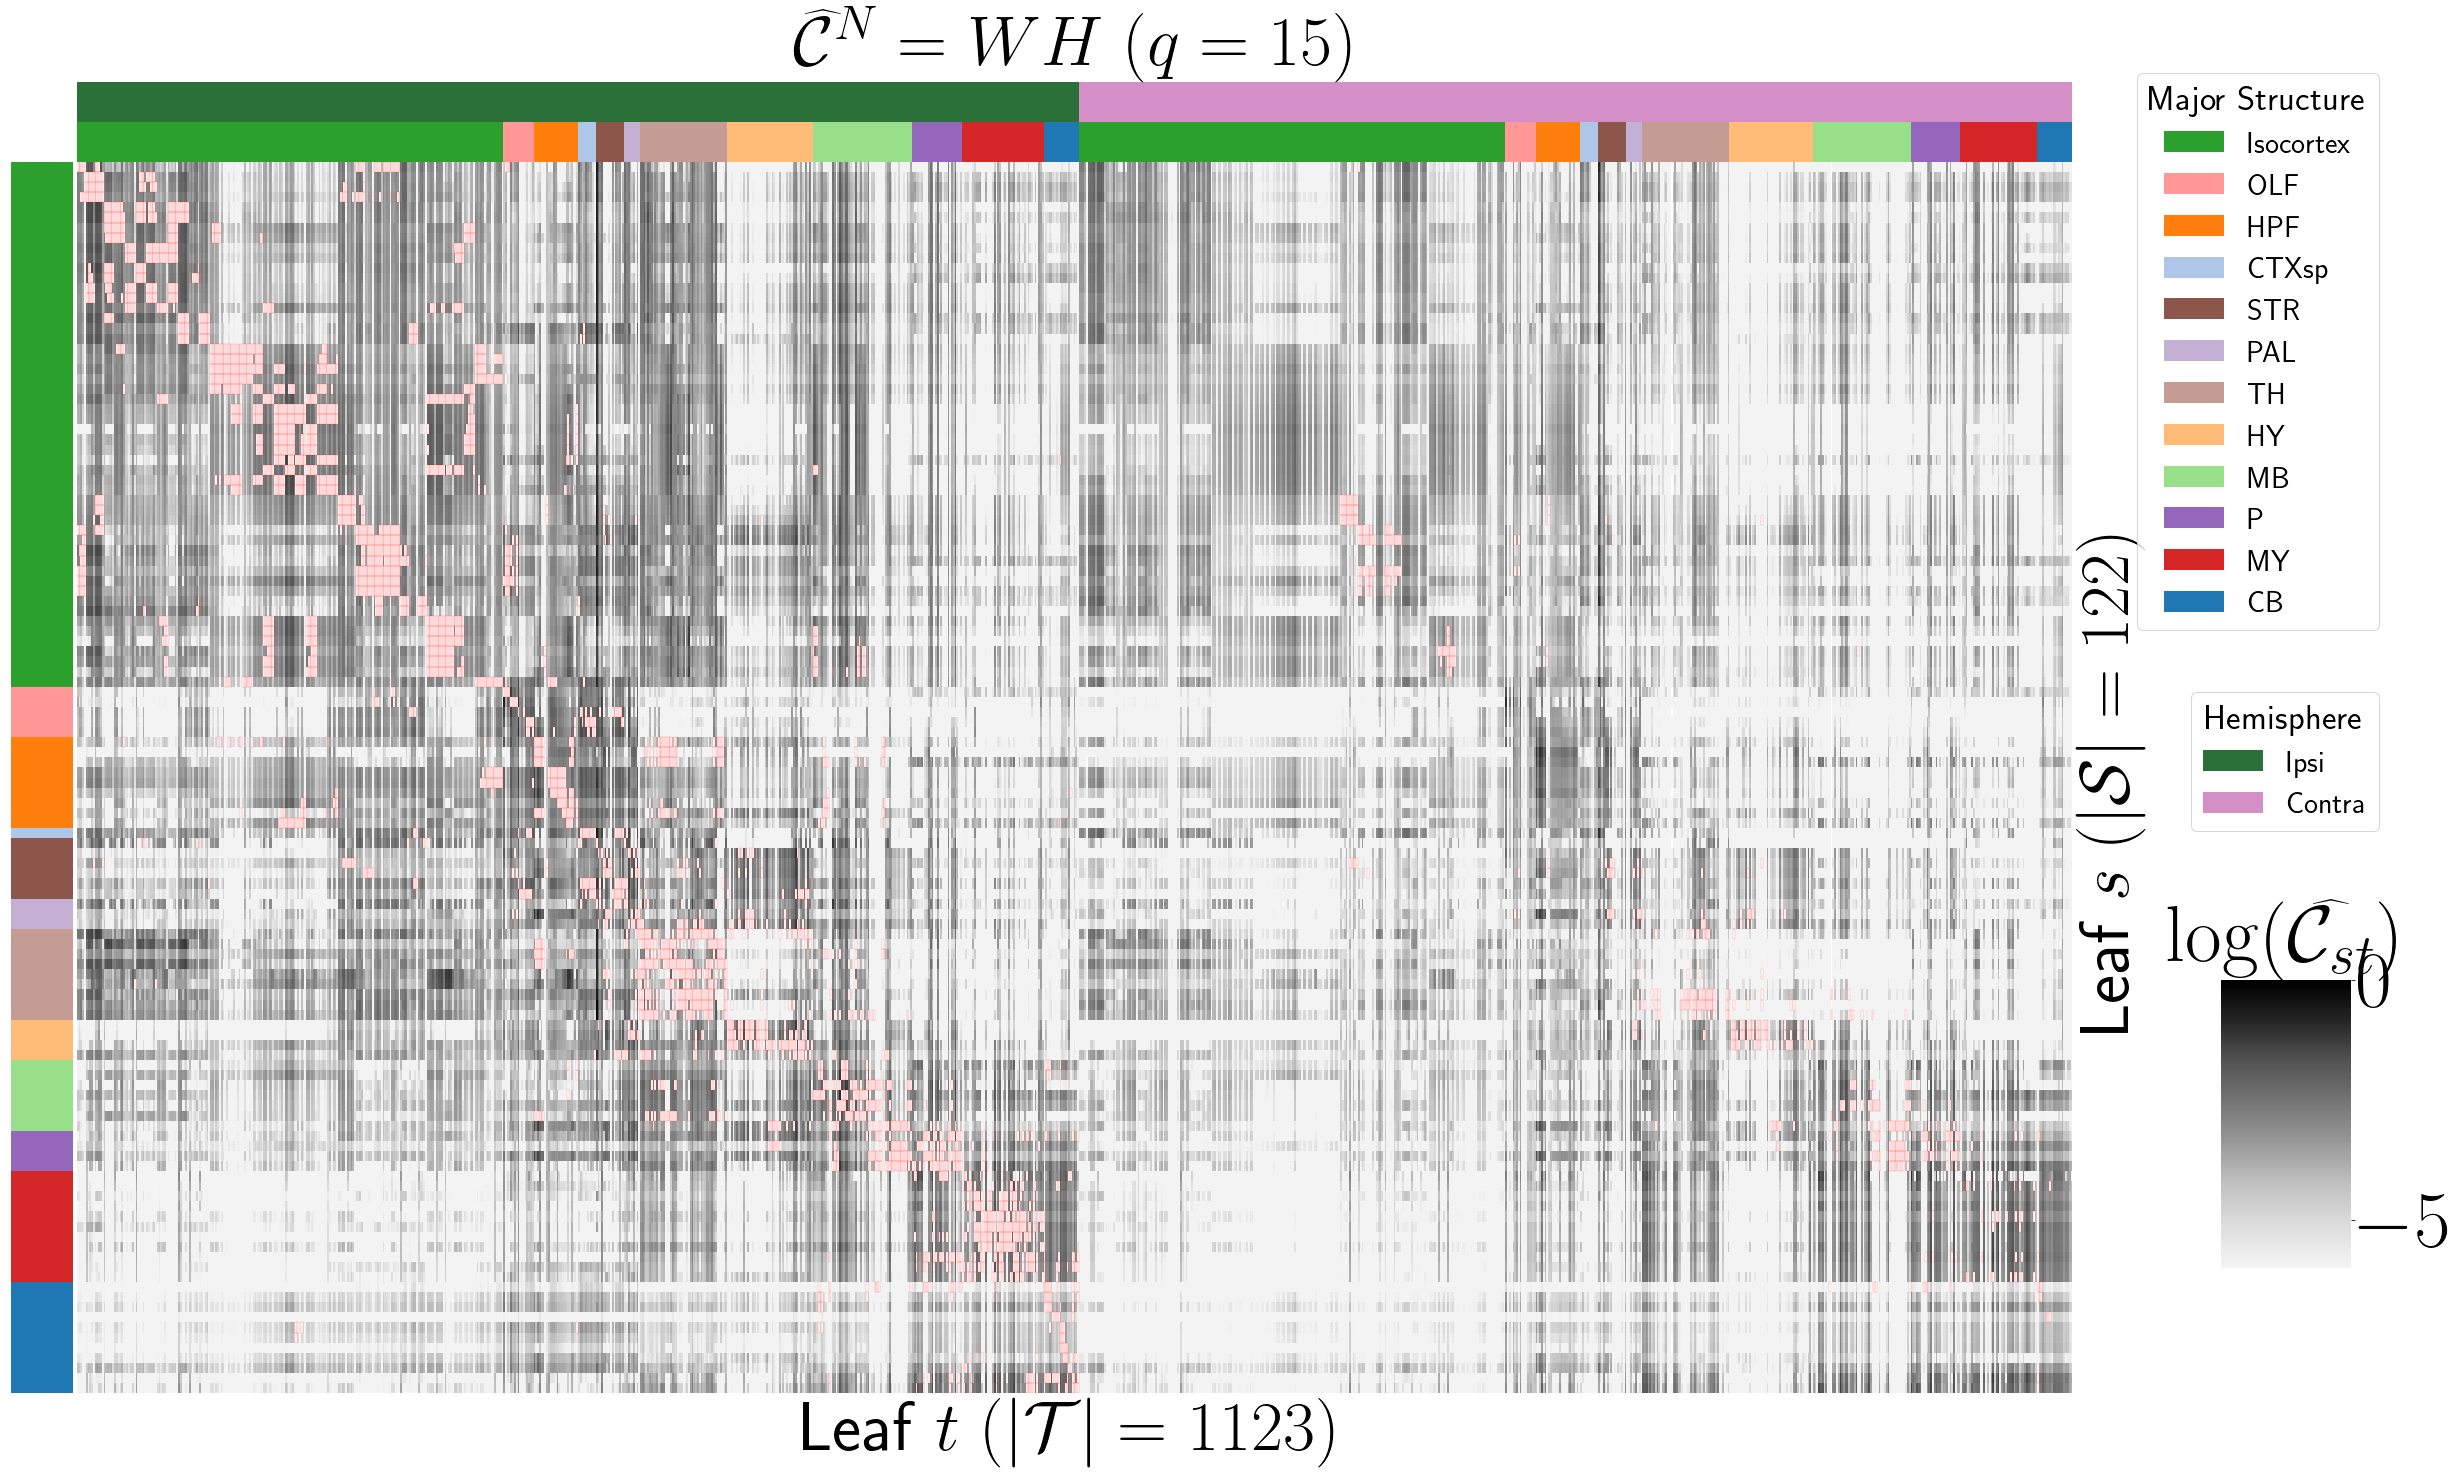

In [84]:
g= sns.clustermap(output, col_cluster = False, row_cluster = False, col_colors=combined_colors_targ, 
                  row_colors = combined_colors_source, figsize = (30,20), cmap = new_cmap, vmin = -6, vmax = 0.,
                 dendrogram_ratio=(0,0.01),cbar_kws={"ticks":[-5,0]}, cbar_pos = [1.03,0.16,.06,.2])
#labels = list(g.ax_cbar.get_yticklabels()).copy()#g.ax_cbar.get_yticklabels()
#print(list(labels))
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_xticklabels([])
g.ax_col_colors.set_yticks([])
g.ax_row_colors.set_xticks([])
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_xticklabels([])

g.ax_heatmap.set_xlabel('Leaf ' + r"$t \; (|\mathcal T| = 1123)$", fontsize = 70)
g.ax_heatmap.set_ylabel('Leaf ' + r"$s \; (|\mathcal S| = 122)$", fontsize = 70)

ax = gcf().add_axes((0.55,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=color_str[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.11, 1.), bbox_transform=gcf().transFigure, fontsize = 30,title_fontsize=35)    

ax2 = gcf().add_axes((0.55,.5,0.,0.))
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
for label in hemis:
    ax2.bar(0, 0, color=color_hemi[label], label=label, linewidth=0.)
l4 = ax2.legend(title='Hemisphere', ncol=1, bbox_to_anchor=(1.11, .57), bbox_transform=gcf().transFigure, fontsize = 30,title_fontsize=35)    
g.ax_cbar.set_title(r"$\log (\widehat{ \mathcal C_{st}})$", rotation=0, fontsize = 80)
g.ax_cbar.set_yticklabels(g.ax_cbar.get_yticklabels(), fontsize=80)
#g.ax_cbar.set_position()

g.ax_col_colors.set_title(r"$\widehat{ \mathcal C}^N = WH \; ( q = 15)$", fontsize = 70)
for i in range(low_values2.shape[0]):
    #print(i)
    g.ax_heatmap.add_patch(Rectangle((low_values2[i][1],low_values2[i][0]), 1, 1, fill=False, edgecolor='red', lw=.15))

plt.margins(x=0,y=0)
g.savefig('paper/KoelleConn_fromlocal_0623/figs/conn_leafs_recon.png', bbox_inches = 'tight',pad_inches = 0)

#g.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/KoelleConnectivity/wt_conn_sumleaf_strength', pad_inches = 0,bbox_inches = 'tight')